In [1]:
import numpy as np
from preprocess import DataSet
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
import keras.backend as K
from keras.callbacks import CSVLogger

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.306 seconds.
Prefix dict has been built succesfully.
/home/wave/software/anaconda/envs/atec/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def fscore(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    pred_p = K.sum(y_pred) + K.epsilon()
    actual_p = K.sum(y_true) + K.epsilon()
    precision = tp / pred_p
    recall = tp / actual_p
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [3]:
def weighted_binary_crossentropy(y_true, y_pred):
    p = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    loss = -(1.4 * y_true * K.log(p) + 0.6 * (1. - y_true) * K.log(1. - p))
    return K.mean(loss)

In [4]:
def my_model(vocab_size, emb_matrix, maxlen, lr=0.001, loss='binary_crossentropy'):
    
    input1 = Input(shape=(maxlen,))
    input2 = Input(shape=(maxlen,))
    
    embedding = Embedding(vocab_size,
                          emb_matrix.shape[1],                          
                          weights=[emb_matrix],
                          input_length=maxlen,
                          trainable=False)    
    
    # conv1d = Conv1D(128, 3, padding='same')
    # pooling1d = MaxPooling1D(pool_size=2, padding='same')
    
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))
    lstm2 = Bidirectional(LSTM(128, return_sequences=True))
        
    x1 = embedding(input1)
    x2 = embedding(input2)
        
    x1 = lstm1(x1)
    x2 = lstm1(x2)
    
    x1 = lstm2(x1)
    x2 = lstm2(x2)
    
    x3 = Multiply()([x1, x2])    
    
    x4 = Subtract()([x1, x2])
    x4 = Lambda(lambda x: K.abs(x))(x4)
    
    x = Concatenate(axis=-1)([x3, x4])
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, kernel_regularizer=regularizers.l2(1e-5))(x)
    
    pred = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5))(x)
    
    model = Model(inputs=[input1, input2], outputs=pred)
    
    model.compile(optimizer=Adam(lr=lr, decay=1e-6),
                  loss=loss,
                  metrics=['accuracy', fscore])
    
    return model

In [5]:
dataset = DataSet(maxlen=80, wordlevel=False, K=8, wv_model='GloVe')
emb_matrix = dataset.get_emb_matrix()
vocab = dataset.vocab

In [6]:
model = my_model(len(vocab), emb_matrix, maxlen=80, lr=0.0005, loss=weighted_binary_crossentropy)
#model.summary()

In [11]:
(x_train, y_train), val_data = dataset.get_data(0)
logger = CSVLogger('./kr_logs/train.log', separator=',', append=False)

In [17]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=val_data, callbacks=[csv_logger])

Train on 92230 samples, validate on 10247 samples
Epoch 1/10
92230/92230 [==============================] - 604s 7ms/step - loss: 0.4232 - acc: 0.7964 - fscore: 0.3680 - val_loss: 0.4092 - val_acc: 0.7649 - val_fscore: 0.4748
Epoch 2/10
92230/92230 [==============================] - 590s 6ms/step - loss: 0.3862 - acc: 0.8032 - fscore: 0.4728 - val_loss: 0.3955 - val_acc: 0.8202 - val_fscore: 0.4793
Epoch 3/10
92230/92230 [==============================] - 589s 6ms/step - loss: 0.3629 - acc: 0.8151 - fscore: 0.5215 - val_loss: 0.3864 - val_acc: 0.7654 - val_fscore: 0.5218
Epoch 4/10
92230/92230 [==============================] - 591s 6ms/step - loss: 0.3437 - acc: 0.8237 - fscore: 0.5531 - val_loss: 0.3694 - val_acc: 0.8131 - val_fscore: 0.5290
Epoch 5/10
92230/92230 [==============================] - 589s 6ms/step - loss: 0.3251 - acc: 0.8319 - fscore: 0.5810 - val_loss: 0.3711 - val_acc: 0.8244 - val_fscore: 0.5324
Epoch 6/10
92230/92230 [==============================] - 587s 6ms/ste

In [18]:
model.save('./saved/g_l_model_2.h5')

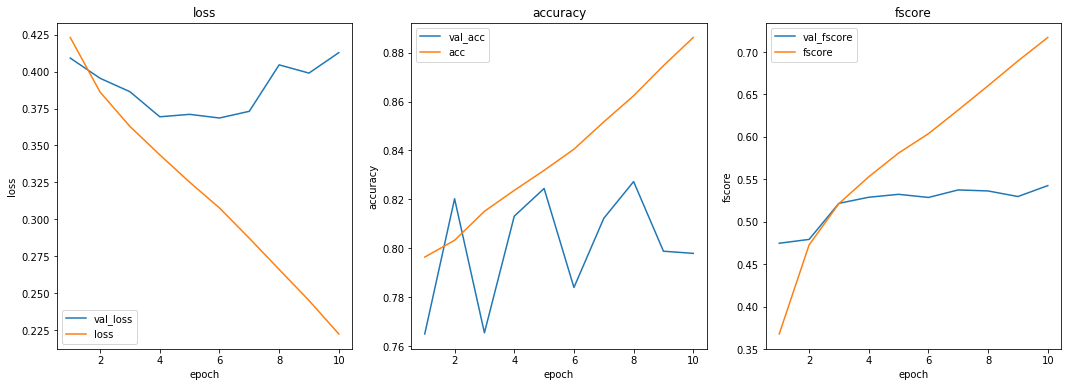

In [20]:
from matplotlib import pyplot as plt

his = hist.history
epochs = list(range(1, 11))
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.title('fscore')
plt.plot(epochs, his['val_fscore'], label='val_fscore')
plt.plot(epochs, his['fscore'], label='fscore')
plt.xlabel('epoch')
plt.ylabel('fscore')
plt.legend()

plt.show()